# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, April 23, 2017

This lab will go through Metric Multi-Dimensional Scaling (mMDS, or simply MDS in the lecture notes) using `scikit-learn`, applying it on a real-world example of airline connections between airports.

Our goal is to **visualize the airports on a 2D plane, grouping together the ones that have a lot of flights in between**.

Note that MDS, like PCA and NMF, does not require labels in any form.

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plot
from matplotlib import cm

In [2]:
import numpy
import pandas as pd

We have a table called `airports.dat`, which is a CSV file.  The schema of `airports.dat` is shown below.
* Airport ID: Unique OpenFlights identifier for this airport.
* Name: Name of airport. May or may not contain the City name.
* City: Main city served by airport. May be spelled differently from Name.
* Country: Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
* IATA: 3-letter IATA code. Null if not assigned/unknown.
* ICAO: 4-letter ICAO code. Null if not assigned.
* Latitude: Decimal degrees, usually to six significant digits. Negative is South, positive is North.
* Longitude: Decimal degrees, usually to six significant digits. Negative is West, positive is East.
* Altitude: In feet.
* Timezone: Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
* DST: Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
* Tz database time zone: Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
* Type: Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
* Source: Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.

In [3]:
airports = pd.read_csv('airports-extended.dat')
airports_reindexed = airports.set_index('Airport ID') # setting Airport ID as index of the table
aid2city = airports_reindexed['City']

We have another table called `routes.dat` which contains the information of all the airlines:

* Airline: 2-letter (IATA) or 3-letter (ICAO) code of the airline.
* Airline ID: Unique OpenFlights identifier for airline (see Airline).
* Source airport: 3-letter (IATA) or 4-letter (ICAO) code of the source airport.
* Source airport ID: Unique OpenFlights identifier for source airport (see Airport)
* Destination airport: 3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
* Destination airport ID: Unique OpenFlights identifier for destination airport (see Airport)
* Codeshare: "Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
* Stops: Number of stops on this flight ("0" for direct)
* Equipment: 3-letter codes for plane type(s) generally used on this flight, separated by spaces

In [6]:
aid2airport = airports_reindexed['IATA'].fillna(airports['ICAO'])
idx2aid = airports['Airport ID'].tolist()
aid2idx = {v: i for i, v in enumerate(idx2aid)}

In [7]:
n_airports = len(aid2idx)

In [11]:
connections = numpy.zeros((n_airports, n_airports))
routes = pd.read_csv('routes.dat')
# Forces conversion of IDs to integers, with strings into NaN.
routes[['Source Airport ID', 'Destination Airport ID']] = (
    routes[['Source Airport ID', 'Destination Airport ID']]
    .apply(pd.to_numeric, errors='coerce')
)
routes = (
    routes.dropna(subset=['Source Airport ID', 'Destination Airport ID'])
    .astype({'Source Airport ID': int, 'Destination Airport ID': int})
)
# We only count "direct" flights as connections.
routes = routes[routes['Stops'] == 0]

for _, row in routes.iterrows():
    sidx = aid2idx[row['Source Airport ID']]
    tidx = aid2idx[row['Destination Airport ID']]
    connections[sidx, tidx] += 1
    connections[tidx, sidx] += 1

Now that we have aggregated the number of direct connections between the airports, we can simply define the "distance" between the airports as the inverse of connections, since our goal dictates that two airports should be considered "similar" (i.e. close to each other) if they have a lot of connections.

In [14]:
weights = 1./connections

/home/gq/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


In [15]:
# We don't want NaNs so we arbitrarily assign a large value to inf's and NaN's.
weights[numpy.isnan(weights)] = 10.
weights[numpy.isinf(weights)] = 10.
print(weights)

[[10.   0.5  0.5 ... 10.  10.  10. ]
 [ 0.5 10.   0.5 ... 10.  10.  10. ]
 [ 0.5  0.5 10.  ... 10.  10.  10. ]
 ...
 [10.  10.  10.  ... 10.  10.  10. ]
 [10.  10.  10.  ... 10.  10.  10. ]
 [10.  10.  10.  ... 10.  10.  10. ]]


In [16]:
per_airport = connections.sum(1)/2.
sorted_idx = numpy.argsort(per_airport)[::-1]

In [17]:
# take the top-100 most-connected airports
n_top = 100
weights_major = weights[sorted_idx[:n_top],:]
weights_major = weights_major[:,sorted_idx[:n_top]]

The core idea of mMDS is very simple: it assigns a vector to each entity so that the pairwise distance between the vectors matches the predefined pairwise distance of the corresponding entities.  Of course, the match won't be perfect, so we take a step back and try to minimize the difference between the pairwise vector distances and the corresponding pairwise entity distances.

When we translate the intuition above to math, choosing the Euclidean distance as "vector distance", we get the equation in the lecture note (omitting the normalization constant):
$$
\min \left[ \sum_{i < j} \left( \lVert \mathbf{z}_i - \mathbf{z}_j \rVert_2 - d_{ij} \right)^2 \right]^{1/2}
$$

Here, we will show how to use `scikit-learn` to run MDS.  Of course, you can implement your own MDS with `autograd`.

<div class="alert alert-info">
**Trivia:** The oldest MDS solves the problem of finding the point coordinates given the pairwise Euclidean distances.  Later it was extended to "any" dissimilarity measure.
</div>

In [18]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed', n_jobs=1, verbose=1)

In [19]:
fitted = mds.fit_transform(weights_major)

breaking at iteration 53 with stress 54564.98817999383
breaking at iteration 153 with stress 54550.83649136511
breaking at iteration 67 with stress 54533.498429451865
breaking at iteration 66 with stress 56109.21825904868


<IPython.core.display.Javascript object>


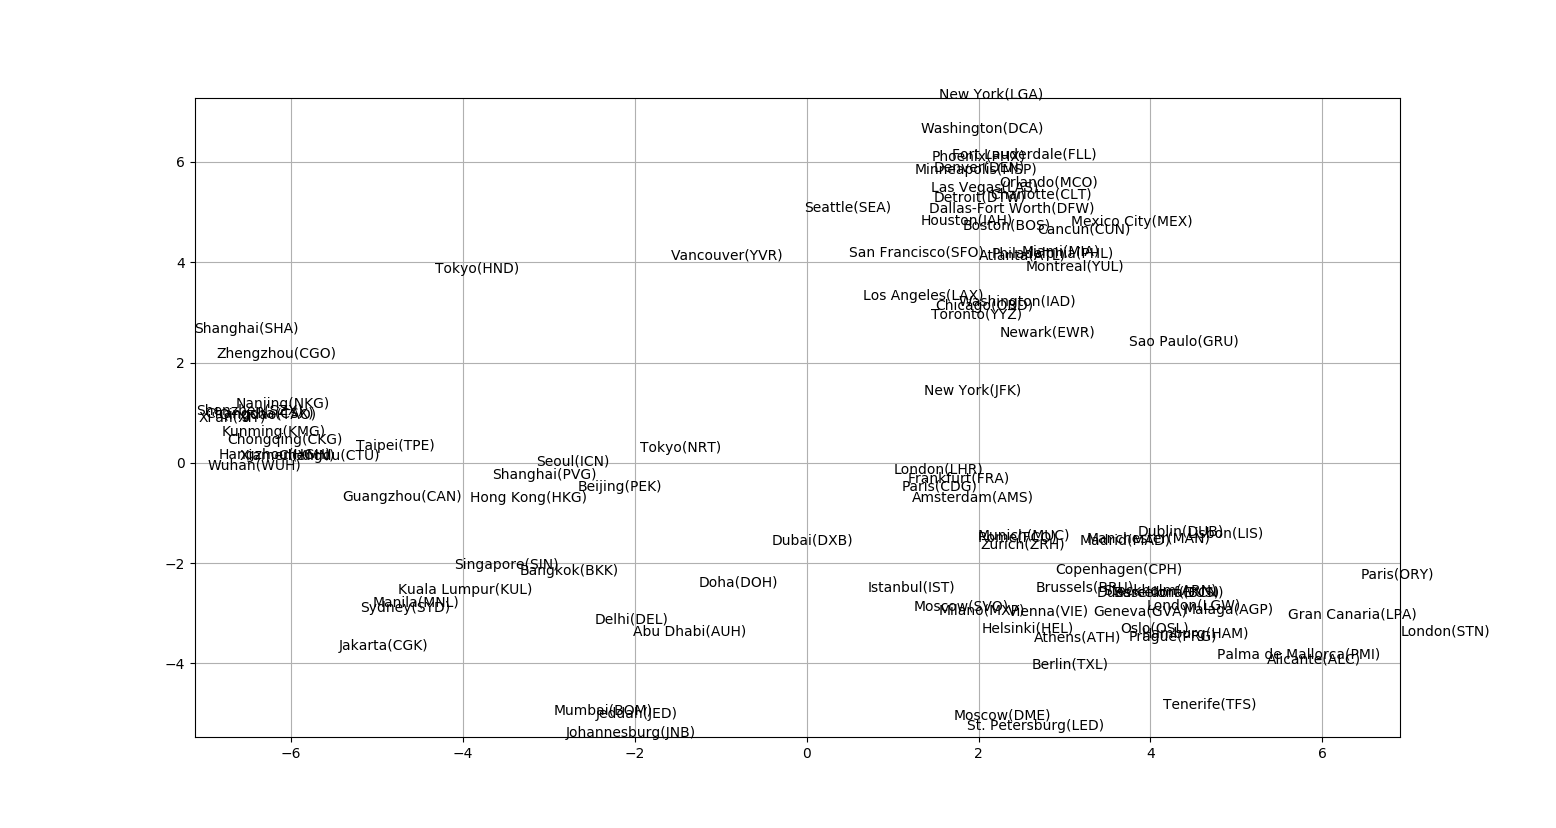

In [22]:
plot.figure()

for ii in xrange(fitted.shape[0]): #sorted_idx[:100]:
    aid = idx2aid[sorted_idx[ii]]
    airport = aid2airport[aid]
    if aid not in aid2city:
        continue
    city = aid2city[aid]
    plot.annotate('{}({})'.format(city.decode('utf8'),airport.decode('utf8')), (fitted[ii,0], fitted[ii,1]))
    
plot.xlim([fitted.min(0)[0], fitted.max(0)[0]])
plot.ylim([fitted.min(0)[1], fitted.max(0)[1]])
plot.grid('on')

plot.show()